# TP : Arbres de décision et fôrets aléatoires


## Résumé

Un arbre de décision est un modèle de classification hiérarchique : à chaque noeud de l'arbre
est associé un test sur une des dimensions $x_i$ de la forme $x_i \{\leq,~ >,~ = \} s$ ($s$ une valeur réelle) qui indique le noeud fils qui doit être sélectionné (par exemple pour un arbre binaire, le fils gauche quand le test est vrai, le fils droit sinon). A chaque feuille de l'arbre est associée une étiquette. Ainsi, la classification d'un exemple consiste en une succession de tests sur les valeurs des dimensions de l'exemple, selon un chemin dans l'arbre de la racine à une des feuilles. La feuille atteinte donne la classe prédite.

L'apprentissage de l'arbre s'effectue de manière récursive top-down : à chaque noeud, l'algorithme choisit le split vertical (seuillage
d'une variable) qui optimise une mesure d'homogénéité sur la partition obtenue (usuellement l'[entropie de shanon](http://fr.wikipedia.org/wiki/Entropie_de_Shannon#D.C3.A9finition_formelle) ou l'[index de Gini](http://fr.wikipedia.org/wiki/Coefficient_de_Gini) : l'entropie d'une partition est d'autant plus petite qu'une classe prédomine dans chaque sous-
ensemble de la partition, elle est nulle lorsque la séparation est parfaite).

Bien que l'algorithme pourrait continuer récursivement jusqu'à n'obtenir que des feuilles contenant un ensemble pur d'exemples (d'une seule classe), on utilise souvent des critères d'arrêts (pourquoi ? - nous y reviendrons lors de ce TP). Les plus communs sont les suivants :

+ le nombre d'exemples minimum que doit contenir un noeud

+ la profondeur maximale de l'arbre

+ la différence de gain de la mesure d'homogénéité entre le noeud père et les noeuds fils





## Prise en main sklearn, données artificielles
scikit-learn est un des modules de machine learning les plus populaires (installation : pip install scikit-learn --user).
Il contient les algos que nous avons déjà vu (knn, noyaux, perceptron, regression), et bien d'autres outils et algorithmes.

In [2]:
#que pour jupyter  !!
%matplotlib inline 
import numpy as np # module pour les outils mathématiques
import matplotlib.pyplot as plt # module pour les outils graphiques
import tools # module fourni en TP1
from sklearn import tree # module pour les arbres
from sklearn import ensemble # module pour les forets
from sklearn import cross_validation as cv
from IPython.display import Image
import pydot

#que pour jupyter  !!
%matplotlib inline 

Tous les modeles d'apprentissage sous scikit fonctionnent de la manière suivante :

+ création du classifieur (ici  **cls=Classifier()**)

+ réglage des paramètres (par exemple la profondeur maximale, le nombre d'exemples par noeud)

+ apprentissage du classifieur par l'intermédiaire de la fonction **cls.fit(data,labels)** 

+ prediction pour de nouveaux exemples : fonction **cls.predict(data)**

+ score du classifieur (précision, pourcentage d'exemples bien classés) : fonction **cls.score(data,labels)**

Pour un arbre de décision, la classe est **tree.DecisionTreeClassfier()**.
Dans le cas des arbres de décisions, nous avons aussi la possibilité d'obtenir l'importance des variables, un score qui est d'autant plus grand que la variable est "utile" pour la classification.

In [10]:
def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,eps=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param eps: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
        #melange de 2 gaussiennes
        xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex/2))
        xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/2))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(int(nbex/2)),-np.ones(int(nbex/2))))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))     
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(int(nbex/2)),-np.ones(int(nbex/2))))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,eps,nbex)
    data[:,1]+=np.random.normal(0,eps,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])



def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])


precision :  0.0
precision (score) :  1.0
|---------X0<=-0.12
|         |---------(-1.0: 500, 1.0: 0)
|---------X0>-0.12
          |---------(-1.0: 0, 1.0: 500)



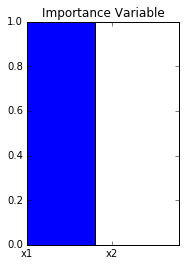

In [16]:
#Initialisation
data,y=gen_arti(data_type=0 ,nbex=1000)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=2 #profondeur maximale de 5
mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille
#Apprentissage
mytree.fit(data,y)

#prediction
pred=mytree.predict(data)
print ("precision : ", (1.*pred!=y).sum()/len(y))

#ou directement pour la precision : 
print ("precision (score) : ",mytree.score(data,y))

#Importance des variables :
plt.subplot(1,2,2)
plt.bar([1,2],mytree.feature_importances_)
plt.title("Importance Variable")
plt.xticks([1,2],["x1","x2"])

#Affichage de l'arbre
with open("mytree.dot","w") as f:
    tree.export_graphviz(mytree,f)

###### Si graphviz n'est pas installe, la fonction suivante permet d'afficher un arbre
def affiche_arbre(tree):
    long = 10
    sep1="|"+"-"*(long-1)
    sepl="|"+" "*(long-1)
    sepr=" "*long
    def aux(node,sep):
        if tree.tree_.children_left[node]<0:
            ls ="(%s)" % (", ".join( "%s: %d" %(tree.classes_[i],int(x)) for i,x
 in enumerate(tree.tree_.value[node].flat)))
            return sep+sep1+"%s\n" % (ls,)
        return (sep+sep1+"X%d<=%0.2f\n"+"%s"+sep+sep1+"X%d>%0.2f\n"+"%s" )% \
                    (tree.tree_.feature[node],tree.tree_.threshold[node],aux(tree.tree_.children_left[node],sep+sepl),
                    tree.tree_.feature[node],tree.tree_.threshold[node],aux(tree.tree_.children_right[node],sep+sepr))
    return aux(0,"")
print(affiche_arbre(mytree))

##On créé un fichier .dot
## Commande sur le shell
## dot -Tpdf mytree.dot -o mytree.pdf

Sur différents jeux de données artificielles (des tps précédents) : 

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'>observer les frontières de décision en fonction de la taille de l'arbe.</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'>faites varier les différents paramètres disponibles (hauteur de l'arbre, nombre d'exemples dans les noeuds par exemple) et tracer la précision en fonction de ces paramètres.
Que remarquez vous sur la précision ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'>Est-ce que cette valeur de précision vous semble une estimation fiable de l'erreur ? Pourquoi ?</font>*


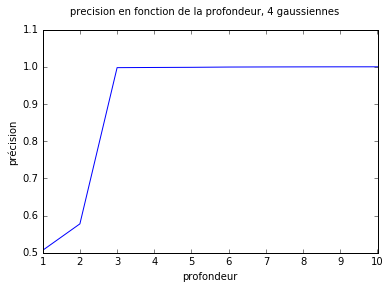

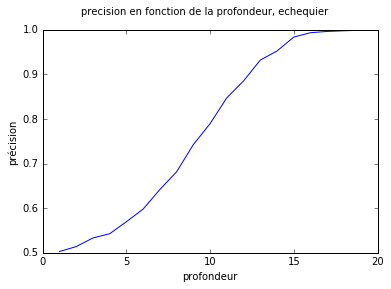

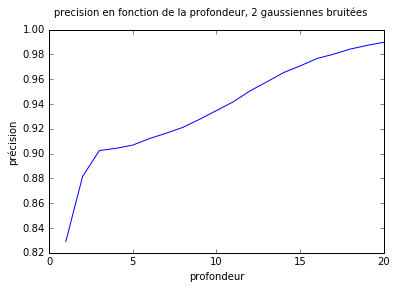

In [85]:
vec2=np.arange(1,11,1) 
#Graphique de la précision en fonction de la profondeur
precision_score=[]

data,y=gen_arti(data_type=1,nbex=15000)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
for i in vec2:
    mytree.max_depth=i #profondeur maximale de 5
    mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction de la profondeur, 4 gaussiennes')
plt.plot(vec2,precision_score)
plt.ylabel('précision')
plt.xlabel('profondeur')
plt.show()

vec2=np.arange(1,21,1) 
#Graphique de la précision en fonction de la profondeur
precision_score=[]

data,y=gen_arti(data_type=2,nbex=15000)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
for i in vec2:
    mytree.max_depth=i #profondeur maximale de 5
    mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction de la profondeur, echequier')
plt.plot(vec2,precision_score)
plt.ylabel('précision')
plt.xlabel('profondeur')
plt.show()

vec2=np.arange(1,21,1) 
#Graphique de la précision en fonction de la profondeur
precision_score=[]

data,y=gen_arti(data_type=0,nbex=15000,eps=1)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
for i in vec2:
    mytree.max_depth=i #profondeur maximale de 5
    mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction de la profondeur, 2 gaussiennes bruitées')
plt.plot(vec2,precision_score)
plt.ylabel('précision')
plt.xlabel('profondeur')
plt.show()

La précision augmente toujours avec la profondeur de l'arbre. On constate par contre que cette evolution n'est pas identique selon le jeu de données.
Pour les 4 gaussiennes, il y a une valeur seuil de la profondeur pour avoir un score de 1. Cette valeur de seuil est de profondeur 3.
Pour l'echequier, l'arbre a besoin d'une profondeur plus importante pour séparer et la croissance de la precision selon la profondeur est quasi linéaire.
Pour deux gausiennes, la croissance est séparée en deux sections quasi-linéaire mais avec des pentes différentes, la rupture se fait pour une profondeur de 3.

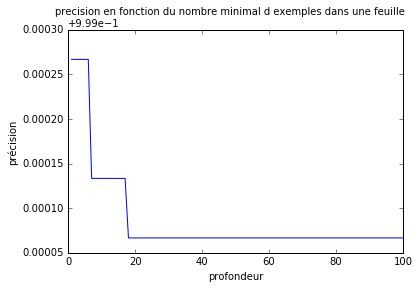

In [83]:
#Graphique de la précision en fonction du nombre minimal d'exemples dans une feuille
vec2=np.arange(1,101,1) 
precision_score=[]

data,y=gen_arti(data_type=1,nbex=15000)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=5 #profondeur maximale de 5
for i in vec2:
    mytree.min_samples_split=i #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction du nombre minimal d exemples dans une feuille')
plt.plot(vec2,precision_score)
plt.ylabel('précision')
plt.xlabel('profondeur')
plt.show()


## Validation croisée : sélection de modèle

Il est rare de disposer en pratique d'un ensemble de test (on préfère inclure le plus grand
nombre de données dans l'ensemble d'apprentissage). Pour sélectionner un modèle tout en considérant le plus grand nombre d'exemples possible pour l'apprentissage, on utilise généralement
une procédure dite de sélection par validation croisée. Pour chaque paramètrisation du problème,
une estimation de l'erreur empirique du classifieur appris est faîte selon la procédure suivante :

+ l'ensemble d'apprentissage $E_{app}$ est partitioné en $n$ ensembles d'apprentissage $\{E_i\}$

+ Pour $i=1..n$

  + l'arbre est appris sur $E_{app}$\ $E_i$

  + l'erreur en test $err(E_i)$ est évaluée sur $E_i$ (qui n'a pas servi à l'apprentissage à cette itération)

+ l'erreur moyenne $err=\frac{1}{n}\sum_{i=1}^n err(E_i)$ est calculée, le modèle sélectionné est celui qui minimise cette erreur


Ci-dessous quelques fonctions utiles pour la sélection de modèle :

In [ ]:
#permet de partager un ensemble en deux ensembles d'apprentissage et de test 
data_train,data_test,y_train,y_test=cv.train_test_split(data,y,test_size=0.3)
mytree.fit(data_train,y_train)
print "precision en test (split 30 %) : ", mytree.score(data_test,y_test)

#permet d'executer une n-validation croisée et d'obtenir le score pour chaque tentative
print "precision en test (10-fold validation) : ",cv.cross_val_score(mytree,data,y,cv=10)

#alternative : obtenir les indices et itérer dessus  
kf= cv.KFold(y.size,n_folds=10)
res_train=[]
res_test=[]
for cvtrain,cvtest in kf:
    mytree.fit(data[cvtrain],y[cvtrain])
    res_train+=[mytree.score(data[cvtrain],y[cvtrain])]
    res_test+=[mytree.score(data[cvtest],y[cvtest])]
print "ou de maniere analogue : "
print "precision en train : ",res_train
print "precision en test : ",res_test
print "moyenne train : ",np.mean(res_train)," (", np.std(res_train),")"             
print "moyenne test : ",np.mean(res_test)," (",np.std(res_test),")"
             
    

*<font style="BACKGROUND-COLOR: lightgray" color='red'>Manipuler sur les différents types de génération artificielle ces fonctions afin de trouver les meilleurs paramètres selon le problème. Tracer l'erreur d'apprentissage et l'erreur de test en fonction des paramètres étudiés. Que se passe-t-il pour des profondeurs trop élevées des arbres ?</font>*

## Classification données USPS

Tester sur les données USPS (en sélectionnant quelques sous-classes). Observer l'importance des variables. Afficher la matrice 2D de la variable importance de chaque pixel de l'image (avec **plt.imshow(matrix)**). Les résultats semble-t-ils cohérents ? 
Utiliser l'algorithme du perceptron fourni par sklearn (**linear_model.Perceptron**) ou le votre et comparer les résultats obtenus pour les poids.

Sur quelques exemples, comparer les performances des arbres et du Perceptron en utilisant la validation croisée pour calibrer au mieux vos modèles. 

Expérimenter également les fôrets aléatoires : c'est une méthode de baging très utilisée, qui consiste à considérer un ensemble d'arbres appris chacun sur un échantillonage aléatoire de la base d'exemples; la classification se fait par vote majoritaire (**enemble.RandomForestClassifier()**).


## Classification sur la base movielens 

La base movielens est une base de données issue d'imdb, qui contient des informations sur des films (le genre, l'année de production, des tags) et des notes attribuées par les utilisateurs. Elle est utilisée généralement pour la recommendation de films. Nous allons l'utiliser dans le cadre de la classification, afin de prédire si un film est bon ou mauvais, dans deux contextes :

+ en prenant en compte uniquement l'information sur le film et le score moyen du film

+ en prenant en compte l'information de l'utilisateur qui score le film

Télécharger l'[archive suivante](http://www-connex.lip6.fr/~baskiotisn/ARF15/imdb_extrait.pkl)

Le bloc de code suivant est utilisé pour  charger et prétraiter les données.


In [ ]:
import cPickle
[data,id2titles, fields]=cPickle.load(file("imdb_extrait.pkl"))
datax = data[:,:32]
datay= np.array([1 if x[33]>6.5 else -1 for x in data]) # seuil de bon film a 6.5


Les informations suivantes sont stockées :

+ fields : liste des champs utilisés (28 genres, durée, couleur ou noir/blanc, année, budget,nombre de votes et rating)

+ data : une matrice, chaque ligne un film, chaque colonne un champs, 1 indique le genre s'applique au film, 0 non.

+ id2titles : pour chaque index de film, le titre du film

### Classification à partir de l'information unique du film
+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Expérimenter les arbres de décisions et le perceptron pour cette tâche. L'ordre de grandeur de chaque dimension joue-t-il un role ? sur quelles dimensions cela peut poser problème ? </font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Sur quelques paramètres, que remarquez vous sur l'erreur d'apprentissage et de test ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> La taille de l'ensemble de test joue-t-elle un rôle ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Tracer les courbes de ces deux erreurs en fonction de la profondeur. Que remarquez vous ? Quels sont les meilleurs paramètres pour l'erreur en apprentissage et en test ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Quelles sont les variables les plus importantes ?  </font>*
